In [1]:
import numpy as np
import nibabel as nib
import scipy.io as sio
from scipy import stats
import pandas as pd
import h5py
import nilearn
from mayavi import mlab
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.offsetbox as offsetbox
from math import pi
%matplotlib inline




In [2]:
##### function to load ROIs and blueprints 
def load_data(mat):   
    mat=h5py.File(mat,'r')
    variables=mat.items()
    for var in variables:
        mat_name=var[0]
        mat_data=var[1]
        mat_data=np.array(mat_data).transpose()
        mat_data=mat_data
    return mat_data

In [3]:
L_pig_data=load_data('./blueprints//L_only_pig.mat')
R_pig_data=load_data('./blueprints//R_only_pig.mat')


In [4]:
with open('./blueprints/structureList_hemiso.txt') as structs:
    structs=structs.read().split('\n')

In [5]:
##### define KL calculation
### Calculate the KL divergence as done in the Mars blueprint paper
def calc_kl(A,B):
    if type(A) == dict:
        A=list(A.values())
        A=np.array(A).transpose()
    else:
            pass
    if type(B) == dict:
        B=list(B.values())
        B=np.array(B).transpose()
    else:
        pass
    
    p=A.shape
    p=p[0]

    ## function takes two numpy arrays that are the blueprints not normalized
    def normalize(BP,p):
        if len(BP.shape) ==1:
            BP=BP.reshape(1,p)
        
        BP[(np.isnan(BP))]=0
        row_sums=BP.sum(axis=1)
        BP=BP/row_sums[:,np.newaxis]
        return BP
    
    A=normalize(A,p)
    A_norm=A.copy()
    B=normalize(B,p)
    B_norm=B.copy()
    Amask= A!=0
    A_invmask=Amask!=1
    Bmask= B !=0
    B_invmask=Bmask!=1
 
    ##### pyhton implementation of Saad Jaabdi's matlab code fo KL divergence
    KL=np.dot(np.multiply(A,(np.log2((A+A_invmask)))),Bmask.transpose()) \
    - np.dot(A,(Bmask*np.log2(B+B_invmask)).transpose()) \
    + np.dot(Amask,(B*np.log2(B+B_invmask)).transpose())\
    - np.dot(Amask*np.log2(A+A_invmask),B.transpose())
    return KL, A_norm,B_norm

In [6]:
#### calculate the KL of the whole cortex respectively
KL,_,_=calc_kl(R_pig_data,L_pig_data)


In [7]:
#### mayavi 

##### function which takes a gifti, and plots a stat numpy array over it
def oh_mayavi(surf,stat,cmap):
    ### parse the gifti
    anat=nib.load(surf)
    coords=anat.darrays[0].data
    x=coords[:,0]
    y=coords[:,1]
    z=coords[:,2]
    triangles=anat.darrays[1].data
    ### start mayavi 
    mlab.init_notebook('png',1500,1500)
    maya=mlab.triangular_mesh(x,y,z,triangles, scalars=stat,colormap=cmap,vmin=0,vmax=np.max(stat))
    
# mlab.figure(bgcolor=(1, 1, 1))
    mlab.view(azimuth=0, elevation=90)
#     mlab.colorbar()
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.)
    mlab.draw()
    maya
    img1=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    mlab.view(azimuth=1, elevation=-90)
    mlab.figure(bgcolor=(1, 1, 1))
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.1)
    mlab.draw()
    
    
    
    img2=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    
    maya
#     mlab.colorbar()
    mlab.close()
    
    return img1,img2
    del img1 
    del img2


In [8]:
R_minKL=np.amin(KL,axis=1)
L_minKL=np.amin(KL,axis=0)

Notebook initialized with png backend.
Notebook initialized with png backend.


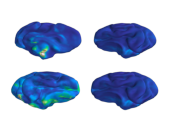

In [9]:
im1,im2=oh_mayavi('./surfaces/pig_surfaces/lh.graymid10k.surf.gii',L_minKL,'terrain')
im4,im3=oh_mayavi('./surfaces/pig_surfaces/rh.graymid10k.surf.gii',R_minKL,'terrain')


plt.subplot(4,2,1)
plt.imshow(im1)
plt.axis('off')
plt.subplot(4,2,2)
plt.imshow(im2)
plt.axis('off')
plt.subplot(4,2,3)
plt.imshow(im4)
plt.axis('off')
plt.subplot(4,2,4)
plt.imshow(im3)
plt.axis('off')


plt.subplots_adjust(wspace = -0.7)
plt.subplots_adjust(hspace = -0.28)


# # im5,im6=oh_mayavi('./corrected_pigs/lh.graymid10k_SIPA2.surf.gii',LS,'hot')
# # im8,im7=oh_mayavi('./corrected_pigs/rh.graymid10k_SIPA2.surf.gii',RS,'gist_heat')


In [10]:
KL,LH,RH=calc_kl(L_pig_data,R_pig_data)

In [11]:
LH=np.mean(LH,axis=0)
RH=np.mean(RH,axis=0)

In [12]:
structs=['atr','cbd','cbt','cbp','cst','fma','fmi','fx','ifof','ilf','mcp','or','ptr','str','unc']

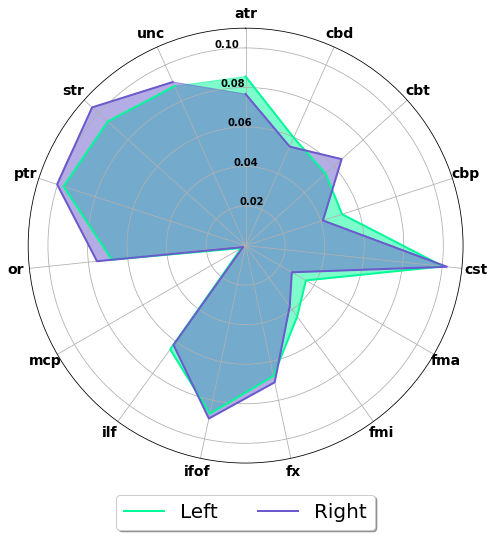

In [13]:
new=structs
#### fancy polar plot 
plt.figure(figsize=(8,8))
N=len(new)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
tracts=plt.xticks(angles[:-1],new,size=14,fontweight='bold')
plt.yticks( color="k", size=10,fontweight='bold')
plt.ylim(0,0.11)
len(new)
len(angles)
###plot left hemi
# ##left 
ax.plot(angles[0:-1], LH, linewidth=2, linestyle='solid',
        label="Left",alpha=1,color='mediumspringgreen')
ax.fill(angles[0:-1], LH,alpha=0.5,color='mediumspringgreen')

# ##pig
ax.plot(angles[0:-1], RH, linewidth=2, linestyle='solid', label="Right",
        alpha=1,color='slateblue')
ax.fill(angles[0:-1], RH,alpha=0.5,color='slateblue')

# #### plot right hemi
# ##human
# ax.plot(angles[0:-1], RH[res], linewidth=2, linestyle='solid',
#         label="Right Human",alpha=1,color='tomato')
# ax.fill(angles[0:-1], RH[res],alpha=0.5,color='tomato')
# ##pig
# ax.plot(angles[0:-1], RP[res], linewidth=2, linestyle='solid', 
#         label="Right Pig",alpha=1,color='darkcyan')
# ax.fill(angles[0:-1], RP[res],alpha=0.5,color='darkcyan')
# ax.yaxis.grid(False)
# # ax.spines['polar'].set_visible(True)
# ax.spines['polar'].set_visible(False) 
# # ax.set_rlabel_position(0)

ax.set_rlabel_position(-9)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4, prop={'size': 20})

# leg=plt.legend(bbox_to_anchor=(0,1),loc='upper right')
# plt.savefig('/Volumes/SC/LAB_BI/LAB/Austin_Benn/papers/tract_paper/figures/left_rightsym.pdf',dpi=300,bbox_inches='tight',transparent=True)

